# EVAC Examination

## Data Exploration

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [464]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 16
numHiddenNodes2 = 16
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_1191/2098144796.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [465]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


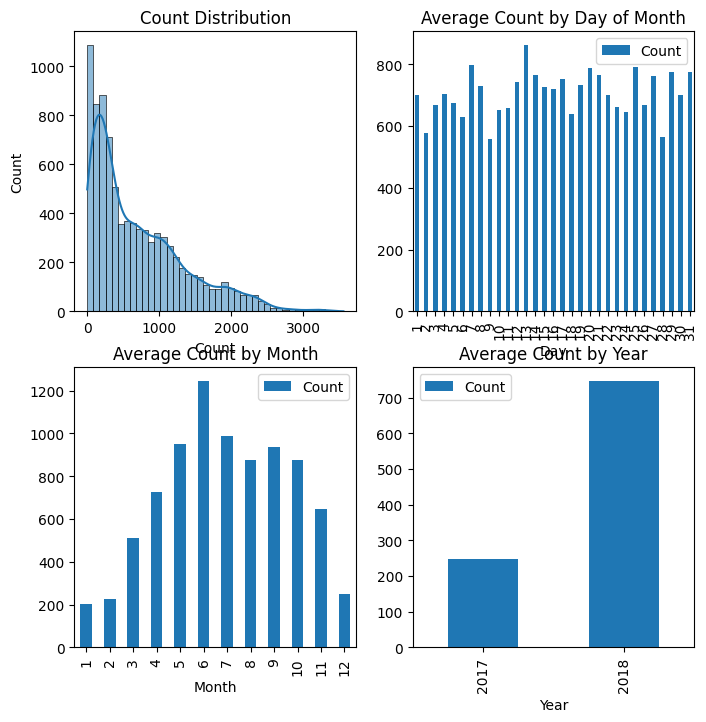

In [466]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


In [467]:
all_data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [468]:
!pip install deap

In [469]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [470]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [471]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [472]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1 # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feedForward(self, inputs):
        inputsBias = list(inputs[:])
        inputsBias.insert(len(inputs),1)             # Add bias input
        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        #output = [self.sigmoid(x) for x in output]   # Activate output layer
        return output

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
      numWeights_I_H1 = self.numHidden1 * self.numInput
      numWeights_H1_H2 = self.numHidden2 * self.numHidden1
      numWeights_H2_O = self.numOutput * self.numHidden2  # noqa F841

      self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
      self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

      self.w_h1_h2 = np.array(
          Wgenome[numWeights_I_H1 : (numWeights_H1_H2 + numWeights_I_H1)]
      )
      self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

      self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2 + numWeights_I_H1) :])
      self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [473]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [474]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [475]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i]]
    output = myNet.feedForward(input)
    fitness += (evdata['Count'][i] - output[0])**2
  return fitness/len(evdata),





In [476]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.4)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet, train_data)
print(baseline)

(51418037.976214945,)


In [477]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [478]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[-0.9252831345124235, 0.4737417720134536, -0.029123495220222173, -0.3495421300441788, -0.6352232317128701, 0.7776785077688355, 0.520302383160155, -0.38764262363366764, -0.2168781609420054, 0.8176939725854024, 0.3992512620107789, 0.44647830336955874, -0.9536545243459991, 0.9599204736717459, 0.005209902221289475, 0.08706556750497985, 0.07248698056128844, -0.2030136741346118, -0.39710686292263064, -0.8684975707580547, 0.9675673794703203, 0.03109671325925545, -0.13144954031293166, 0.20302498150925574, -0.6229229666349105, 0.836610700935182, -0.16711375951135143, 0.2478675810157389, 0.5778203845336765, -0.20930991802614551, -0.6497820514044612, -0.1156971763652117, 0.836191383801036, -0.7336994522062841, -0.9893765986929115, -0.5461576641453258, 0.6868923797871289, -0.5791694660194127, 0.5659550719457103, 0.23577301495064806, -0.14207884710473095, 0.8746337279949179, -0.39622639540535665, 0.9859179951020003, -0.9878880034705573, 0.6906122503081416, 0.8383363911166948, -0.3553746806674749, -

In [479]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=100)

In [480]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [481]:
NGEN = 400

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)



-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [482]:
print(logbook)
print([i[:1] for i in hof.items[:10]])
hof.items[0]
hof.items[1]


avg        	gen	max        	min   	std        
1.02507e+07	0  	1.8711e+08 	418057	2.30431e+07
8.65985e+06	1  	6.51671e+07	430643	1.27881e+07
1.03672e+07	2  	1.05867e+08	391777	1.67589e+07
1.19043e+07	3  	7.84659e+07	425443	1.70886e+07
1.62199e+07	4  	2.83402e+08	441223	3.28529e+07
1.62594e+07	5  	1.5483e+08 	396393	2.67577e+07
2.28274e+07	6  	3.35066e+08	424508	4.35171e+07
2.55496e+07	7  	4.17997e+08	446378	5.491e+07  
2.90055e+07	8  	2.32322e+08	456993	5.1989e+07 
2.54958e+07	9  	2.94205e+08	374347	4.29703e+07
2.61237e+07	10 	3.08292e+08	372176	4.66573e+07
2.34241e+07	11 	3.51955e+08	407748	4.88632e+07
2.16417e+07	12 	1.89176e+08	364178	3.39938e+07
2.13384e+07	13 	3.7209e+08 	394566	4.61082e+07
3.76013e+07	14 	6.49408e+08	392827	8.55474e+07
1.84631e+07	15 	3.40454e+08	283918	4.57986e+07
1.90208e+07	16 	1.31822e+08	254485	2.90717e+07
2.02612e+07	17 	2.48204e+08	326662	3.74605e+07
2.36744e+07	18 	3.75773e+08	263649	4.31434e+07
3.40042e+07	19 	3.42956e+08	499539	5.72902e+07
2.82922e+07	2

IndexError: list index out of range

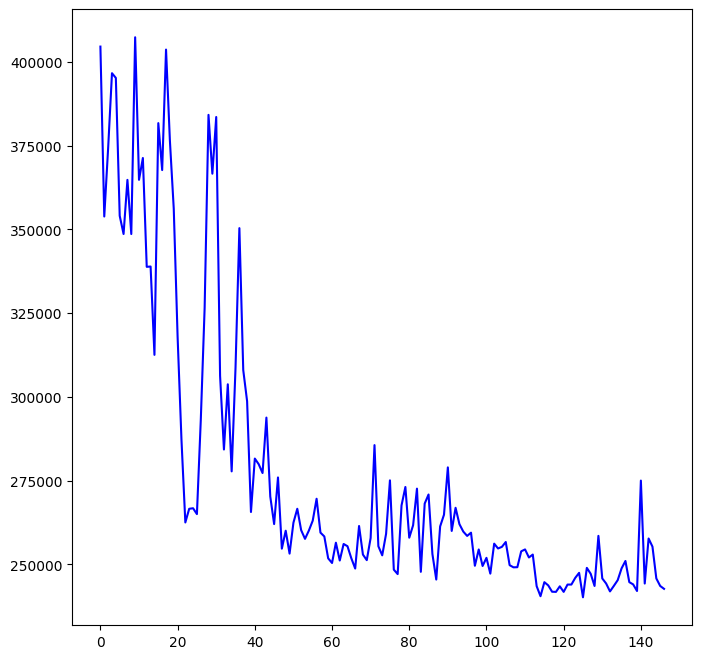

In [ ]:
## graph of the min fitness value over generations
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(gen, fit_mins, "b", label="Minimum")


[0.7334524547665747, -3.436412383825249, -0.9817952512231398, -0.4983337233663103, 2.129232136572949, -6.277688625489691, -0.23880261952605608, -0.7012962444394761, 2.3370131798173457, -3.8221457217606787, 0.3021651797924263, 0.01282230604275425, -2.0725590949054187, 5.226759274633989, -3.030654841699868, 0.2650562138085132, 9.72472869897956, 3.8277992917155466, -3.9805192602482604, 3.434751096777557, 0.8987187732652333, -2.712949177815547, -4.393773802370536, -0.529127773230833, 4.853852557558045, 0.07360624121023396, 3.2943224166045626, -7.395668403841118, -2.0110526856662494, 1.462915791324427, -3.6271859692560255, -6.6255945408584065, -4.057001966956369, -5.7896441959459946, 0.27202593213921034, 6.10371846218783, -4.324835248520663, 0.20470101465488555, -2.718844158057915, 4.189657375435583, -4.100322502981312, -1.2603448135125426, 7.19330788445759, -4.357042552504606, -0.924553297035468, -1.2386756894436899, -3.6335841158102866, 5.367032536637978, 1.4641833737271628, -6.6897357862

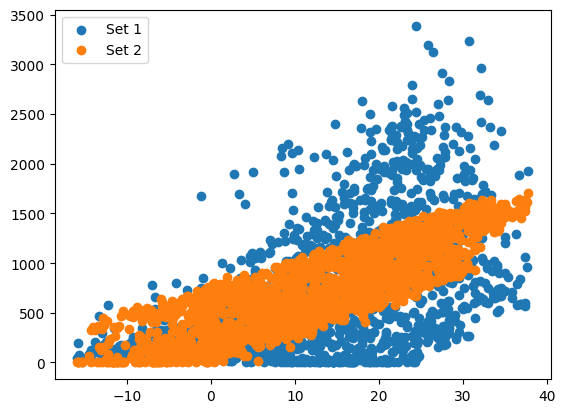

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = tools.selBest(pop, 1)[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

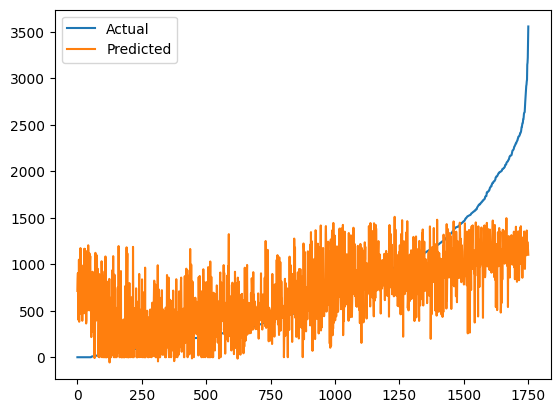

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[6.664079225478184, 0.4581185163475491, -1.318477734390295, -1.3606332540966655, -2.1046796780725225, 3.6616626491030804, -5.8926519716776875, 4.608725528990066, -10.611705831867026, 8.761602177769475, 0.20851616758092473, 2.60835726890931, 7.26807962837511, -1.8900903717089623, -5.97635399102484, 2.276610160010599, 0.21816324354205058, 5.7724222886476, -0.6898551126653188, -8.921762735718458, 0.16739577936584932, -5.9761160009675525, -0.8639841330819393, 0.4849042951951254, -5.395043950525465, 9.548077243804357, -5.766902118526401, -1.2019012935577358, 3.4827574597287123, -3.652798707858401, -1.2615631520333754, -6.631989498408493, 4.55117664423373, -4.142557784790032, 9.865703665286365, -4.667818842446607, 2.8607301305902766, -1.1791373661936522, -2.9498601302910172, 4.957647985599753, 2.3089696547425573, -0.18453367201739704, 2.9483088668816952, 2.9201742929400796, 2.192025258216973, 1.5488342679501508, -1.9872185330632073, 1.7054361616060665, 2.1043349961852846, -1.933464176304157,

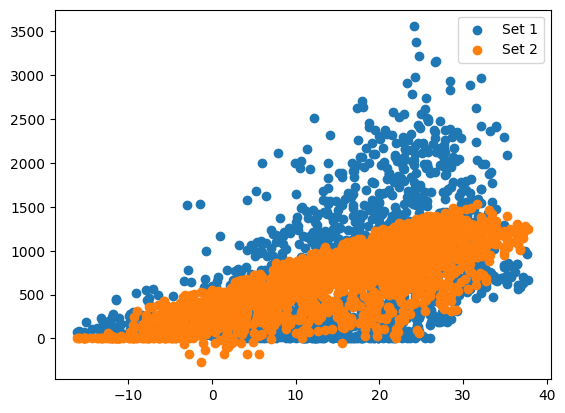

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([828.72854714]), array([916.27916943]), array([733.0545866]), array([347.13037602]), array([819.62543574]), array([358.83183246]), array([1084.62865926]), array([291.999865]), array([633.6027367]), array([621.97552232]), array([768.22010606]), array([553.78064089]), array([1230.57158002]), array([616.52564512]), array([693.5824046]), array([896.3030733]), array([510.64787761]), array([587.41042337]), array([707.82584498]), array([306.33322622]), array([940.8760776]), array([707.27244516]), array([925.54204276]), array([833.63685428]), array([1078.13448763]), array([623.47998313]), array([617.12816994]), array([1237.37323908]), array([667.12011158]), array([1215.13147998]), array([805.70048192]), array([452.17432082]), array([795.96905143]), array([798.0336002]), array([63.74512468]), array([108.89319486]), array([986.1127863]), array([1180.88992043]), array([755.59700396]), array([301.69522755]), array([952.20816184]), array([748.4913577]), array([1245.37729651]), array([1148.30

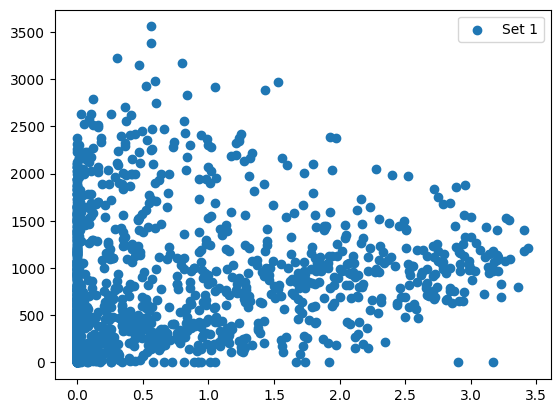

[6.664079225478184, 0.4581185163475491, -1.318477734390295, -1.3606332540966655, -2.1046796780725225, 3.6616626491030804, -5.8926519716776875, 4.608725528990066, -10.611705831867026, 8.761602177769475, 0.20851616758092473, 2.60835726890931, 7.26807962837511, -1.8900903717089623, -5.97635399102484, 2.276610160010599, 0.21816324354205058, 5.7724222886476, -0.6898551126653188, -8.921762735718458, 0.16739577936584932, -5.9761160009675525, -0.8639841330819393, 0.4849042951951254, -5.395043950525465, 9.548077243804357, -5.766902118526401, -1.2019012935577358, 3.4827574597287123, -3.652798707858401, -1.2615631520333754, -6.631989498408493, 4.55117664423373, -4.142557784790032, 9.865703665286365, -4.667818842446607, 2.8607301305902766, -1.1791373661936522, -2.9498601302910172, 4.957647985599753, 2.3089696547425573, -0.18453367201739704, 2.9483088668816952, 2.9201742929400796, 2.192025258216973, 1.5488342679501508, -1.9872185330632073, 1.7054361616060665, 2.1043349961852846, -1.933464176304157,

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Sunshine'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

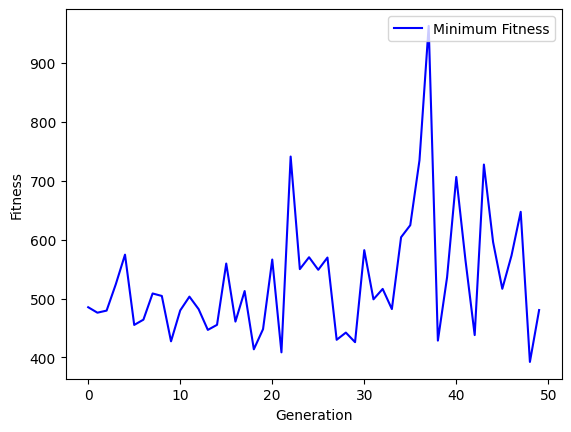

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()